# Predicting Earnings of French People
***

***Piotr Skalski - 02.11.2017***

<img src='http://res.freestockphotos.biz/pictures/8/8163-euro-coins-and-bills-pv.jpg'>

## Table of Contents
***
* [1. Introduction](#introduction) <br>
* [2. Importing dataset and data preprocessing](#importing_dataset_and_data_preprocessing) <br>
   * [2.1. Importing essential libraries](#importing_essential_libraries) <br>
   * [2.2. Importing datasets](#importing_datasets) <br>
   * [2.3. Let's summarize the datasets](#lets_summarize_the_dataset) <br>
   * [2.4. Data preprocessing & feature engineering](#data_preprocessing) <br>
      * [2.4.1. Salary dataset preprocessing](#salary_dataset_preprocessing) <br>
      * [2.4.2. Geography dataset preprocessing](#geography_dataset_preprocessing) <br>
      * [2.4.3. Merging datasets](#merging_datasets) <br>
      * [2.4.4. Splitting dataset into training and testset](#splitting_dataset_into_training_and_testset) <br>
* [3. Prediction](#prediction) <br>
   * [3.1. Random Forest Regressor](#random_forest_regressor) <br>
***

## 1. Introduction
<a id="introduction"></a>

The purpose of this kernel is to create a model that allow for predicting earnings in France, based on some basic information about the employee and where he lives. The analysis carried out here is largely basedo on conclusions from <a href="https://www.kaggle.com/skalskip/how-big-is-french-industry-data-visualization">How big is French Industry? [Data Visualization]</a> [1]. To fully understand the decisions we'll make while creating a model, it is a good idea to read above notebook.

I also note that I am a novice in Machine Learning and Data Science. Thanks in advance for any suggestions and hints. Please share with me your ideas on the features I can use.

## 2. Importing dataset and data preprocessing
<a id="importing_dataset_and_data_preprocessing"></a>

### 2.1. Importing essential libraries
<a id="importing_essential_libraries"></a>

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.optimize import curve_fit
import seaborn as sns

from math import radians, cos, sin, asin, sqrt

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

### 2.2. Importing datasets
<a id="importing_datasets"></a>

In [2]:
# Datasets
geography = pd.read_csv("../00_Datasets/French_firms/name_geographic_information.csv")
industry = pd.read_csv("../00_Datasets/French_firms/base_etablissement_par_tranche_effectif.csv")
salary = pd.read_csv("../00_Datasets/French_firms/net_salary_per_town_categories.csv")
population = pd.read_csv("../00_Datasets/French_firms/population.csv")
# Geojson for map creations
departments_map = gpd.read_file('../00_Datasets/French_firms/departements.geojson')

C:\Users\AFGHAN92\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



### 2.3. Let's summarize the datasets
<a id="lets_summarize_the_dataset"></a>

In [3]:
geography.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36840 entries, 0 to 36839
Data columns (total 14 columns):
EU_circo                  36840 non-null object
code_région               36840 non-null int64
nom_région                36840 non-null object
chef.lieu_région          36840 non-null object
numéro_département        36840 non-null object
nom_département           36840 non-null object
préfecture                36840 non-null object
numéro_circonscription    36840 non-null int64
nom_commune               36840 non-null object
codes_postaux             36840 non-null object
code_insee                36840 non-null int64
latitude                  33911 non-null float64
longitude                 33999 non-null object
éloignement               33878 non-null float64
dtypes: float64(2), int64(3), object(9)
memory usage: 3.9+ MB


In [4]:
industry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36681 entries, 0 to 36680
Data columns (total 14 columns):
CODGEO      36681 non-null object
LIBGEO      36681 non-null object
REG         36681 non-null int64
DEP         36681 non-null object
E14TST      36681 non-null int64
E14TS0ND    36681 non-null int64
E14TS1      36681 non-null int64
E14TS6      36681 non-null int64
E14TS10     36681 non-null int64
E14TS20     36681 non-null int64
E14TS50     36681 non-null int64
E14TS100    36681 non-null int64
E14TS200    36681 non-null int64
E14TS500    36681 non-null int64
dtypes: int64(11), object(3)
memory usage: 3.9+ MB


In [5]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5136 entries, 0 to 5135
Data columns (total 26 columns):
CODGEO       5136 non-null object
LIBGEO       5136 non-null object
SNHM14       5136 non-null float64
SNHMC14      5136 non-null float64
SNHMP14      5136 non-null float64
SNHME14      5136 non-null float64
SNHMO14      5136 non-null float64
SNHMF14      5136 non-null float64
SNHMFC14     5136 non-null float64
SNHMFP14     5136 non-null float64
SNHMFE14     5136 non-null float64
SNHMFO14     5136 non-null float64
SNHMH14      5136 non-null float64
SNHMHC14     5136 non-null float64
SNHMHP14     5136 non-null float64
SNHMHE14     5136 non-null float64
SNHMHO14     5136 non-null float64
SNHM1814     5136 non-null float64
SNHM2614     5136 non-null float64
SNHM5014     5136 non-null float64
SNHMF1814    5136 non-null float64
SNHMF2614    5136 non-null float64
SNHMF5014    5136 non-null float64
SNHMH1814    5136 non-null float64
SNHMH2614    5136 non-null float64
SNHMH5014    5136 no

In [6]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8536584 entries, 0 to 8536583
Data columns (total 7 columns):
NIVGEO       object
CODGEO       object
LIBGEO       object
MOCO         int64
AGEQ80_17    int64
SEXE         int64
NB           int64
dtypes: int64(4), object(3)
memory usage: 455.9+ MB


### 2.4. Data preprocessing & feature engineering
<a id="data_preprocessing"></a>

<b>NOTE:</b> As you can see our dataset consists of four separate files, which store different types of information. Unfortunately, the information in these files is often contaminated or incomplete. At this point our task is to clean up the data and merge four files into one consistent DataFrame which can be used to train the model.

### 2.4.1. Salary dataset preprocessing
<a id="salary_dataset_preprocessing"></a>

<b>NOTE:</b> Salary dataset contains key information on the level of earnings of French citizens according to their place of residence, gender, occupation and age. Due to the very unfavorable data structure we will be forced to create new DataFrame and fill it based on properly processed data from salary dataset.

In [7]:
salary = salary[salary["CODGEO"].apply(lambda x: str(x).isdigit())]
salary["CODGEO"] = salary["CODGEO"].astype(int)

In [8]:
salary.describe()

,CODGEO,SNHM14,SNHMC14,SNHMP14,SNHME14,SNHMO14,SNHMF14,SNHMFC14,SNHMFP14,SNHMFE14,...,SNHMHO14,SNHM1814,SNHM2614,SNHM5014,SNHMF1814,SNHMF2614,SNHMF5014,SNHMH1814,SNHMH2614,SNHMH5014
count,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,...,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000
mean,52531.824946,13.712551,23.711886,14.571843,10.566379,11.238712,12.042295,20.226376,13.274878,10.310456,...,11.501547,9.549501,13.502330,15.882671,9.162581,12.060329,13.175798,9.819405,14.493793,17.688154
std,25781.402402,2.562868,2.836451,1.487597,0.812953,1.224076,1.790723,2.327173,0.990423,0.748591,...,1.291991,0.997259,2.365774,3.591603,0.453437,1.827818,2.252915,1.538884,2.855326,4.536457
min,1004.000000,10.200000,16.000000,11.600000,8.700000,8.300000,9.300000,12.000000,10.600000,8.700000,...,8.900000,7.900000,9.700000,10.500000,7.500000,9.100000,9.500000,7.800000,9.600000,10.800000
25%,33036.500000,12.100000,21.900000,13.800000,10.000000,10.600000,10.900000,18.800000,12.600000,9.800000,...,10.800000,9.200000,12.000000,13.700000,8.900000,10.900000,11.700000,9.400000,12.700000,14.900000
50%,56132.000000,13.000000,23.200000,14.400000,10.400000,11.000000,11.500000,20.000000,13.100000,10.100000,...,11.300000,9.500000,12.900000,15.000000,9.100000,11.600000,12.600000,9.700000,13.800000,16.600000
75%,74088.000000,14.500000,24.900000,15.100000,10.900000,11.600000,12.700000,21.400000,13.800000,10.600000,...,11.900000,9.700000,14.300000,16.900000,9.400000,12.700000,14.000000,10.000000,15.500000,19.000000
max,97424.000000,43.300000,51.500000,54.600000,17.500000,46.300000,26.700000,35.500000,19.000000,16.100000,...,53.200000,60.600000,38.100000,56.900000,12.000000,26.600000,31.000000,93.300000,45.400000,68.600000


<b>NOTE:</b> Let's save a copy of salary dataset, in case we will need it later. 

In [9]:
salary_copy = salary.copy()

<b>NOTE:</b> As we have seen in [1] there is a strong connection between sex, age and occupation, and the amount of money earned. Unfortunately, due to the way dataset was build, we can not use all of these attributes at the same time. Firstly, let's look at how the pay varies depending on gender and age.

In [10]:
age = ["18-25 years old", "26-50 years old", ">50 years old"]
woman_age = ["SNHMF1814", "SNHMF2614", "SNHMF5014"]
woman_salary_age = salary[woman_age].mean().tolist()
man_age = ["SNHMH1814", "SNHMH2614", "SNHMH5014"]
man_salary_age = salary[man_age].mean().tolist()

dif_in_prc_age = []
for w, m in zip(woman_salary_age, man_salary_age):
    dif_in_prc_age.append(round(abs(w-m)/m * 100, 2))
    
trace1 = go.Bar(
    x = age,
    y = woman_salary_age,
    name='Women',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)
trace2 = go.Bar(
    x = age,
    y = man_salary_age,
    name='Men',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    )
)

trace3 = go.Scatter(
    x = age,
    y = dif_in_prc_age,
    name='Earnings difference',
    mode = 'lines+markers',
    yaxis='y2'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title = 'Age and sex are',
    width=850,
    height=500,
    paper_bgcolor='rgb(244, 238, 225)',
    plot_bgcolor='rgb(244, 238, 225)',
    yaxis = dict(
        title= 'Average earnings [€/hour]',
        anchor = 'x',
        rangemode='tozero'
    ),
    xaxis = dict(title= 'Age'),
    
    yaxis2=dict(
        title='Earnings difference',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right',
        anchor = 'x',
        rangemode = 'tozero',
        dtick = 7.3
    ),
    #legend=dict(x=-.1, y=1.2)
    legend=dict(x=0.72, y=0.05)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [11]:
positions = ["Executive", "Middle manager", "Employee", "Worker"]
woman_positions = ["SNHMFC14", "SNHMFP14", "SNHMFE14", "SNHMFO14"]
woman_salary_positions = salary[woman_positions].mean().tolist()
man_positions = ["SNHMHC14", "SNHMHP14", "SNHMHE14", "SNHMHO14"]
man_salary_positions = salary[man_positions].mean().tolist()

dif_in_prc = []
for w, m in zip(woman_salary_positions, man_salary_positions):
    dif_in_prc.append(round(abs(w-m)/m * 100, 2))

trace1 = go.Bar(
    x = positions,
    y = woman_salary_positions,
    name='Women',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)
trace2 = go.Bar(
    x = positions,
    y = man_salary_positions,
    name='Men',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    )
)

trace3 = go.Scatter(
    x = positions,
    y = dif_in_prc,
    name='Earnings difference',
    mode = 'lines+markers',
    yaxis='y2'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title = 'Stereotype is real',
    width=850,
    height=500,
    paper_bgcolor='rgb(244, 238, 225)',
    plot_bgcolor='rgb(244, 238, 225)',
    yaxis = dict(
        title= 'Average earnings [€/hour]',
        anchor = 'x',
        rangemode='tozero'
    ),
    xaxis = dict(title= 'Position'),
    
    yaxis2=dict(
        title='Earnings difference',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right',
        anchor = 'x',
        rangemode = 'tozero',
        dtick = 8
    ),
    #legend=dict(x=-.1, y=1.2)
    legend=dict(x=0.05, y=0.05)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

<b>NOTE:</b> Let's create new DataFrame that will separate information for different age groups. DataFrame will have four columns: "CODGEO", "SEX" (1 - for woman, 2 - for man), "AGE" (1 - for age between 18-25 years, 2 - for age between 26-50 years, 3 - for age over 50 years) and "WAGE" that will hold mean net salary per hour.

In [17]:
row_fields = {}
row_fields["SNHMFC14"] = {"SEX": 1, "POSITION": 4}
row_fields["SNHMFP14"] = {"SEX": 1, "POSITION": 3}
row_fields["SNHMFE14"] = {"SEX": 1, "POSITION": 2}
row_fields["SNHMFO14"] = {"SEX": 1, "POSITION": 1}
row_fields["SNHMHC14"] = {"SEX": 2, "POSITION": 4}
row_fields["SNHMHP14"] = {"SEX": 2, "POSITION": 3}
row_fields["SNHMHE14"] = {"SEX": 2, "POSITION": 2}
row_fields["SNHMHO14"] = {"SEX": 2, "POSITION": 1}

reformatted_salary = []
for index, row in salary.iterrows():
    for key, value in row_fields.items(): 
        row_dict = {}
        row_dict["CODGEO"] = row["CODGEO"]
        row_dict["SEX"] = value["SEX"]
        row_dict["POSITION"] = value["POSITION"]
        row_dict["WAGE"] = row[key]
        reformatted_salary.append(row_dict)
        
reformatted_salary = pd.DataFrame(reformatted_salary)  

<b>NOTE: </b> Let's check if all the operations are done correctly.

In [18]:
reformatted_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40856 entries, 0 to 40855
Data columns (total 4 columns):
CODGEO      40856 non-null int64
POSITION    40856 non-null int64
SEX         40856 non-null int64
WAGE        40856 non-null float64
dtypes: float64(1), int64(3)
memory usage: 1.2 MB


### 2.4.2. Geography dataset preprocessing
<a id="geography_dataset_preprocessing"></a>

<b>NOTE:</b> During our analysis in [1] we have noticed that the average earning in districts close to Paris is definitely higher than in the rest of the country. Similarly, in cities located in the vicinity of provincial towns, the average income is higher than in the rest of the region. Let's create two new features: PARIS_CLOSE with values equal 1 or 0, depending on whether the place is closer or farther than 30 km from the center of Paris; MAJOR_CITY_DISTANCE: which will represent the distance in kilometers from the provincial town. 

<b>NOTE:</b> Unfortunately, some of the data in geography DataFrame is incorrect or incomplete. First we will focus on longitude column. We will convert commas to dots to create a correct number [#1]. Then we will delete the incorrect entries [#2] and empty fields [#3]. Finally, we will switch the column type to float [#4].

In [19]:
# 1
geography["longitude"] = geography["longitude"].apply(lambda x: str(x).replace(',','.'))
# 2
mask = geography["longitude"] == '-'
geography.drop(geography[mask].index, inplace=True)
# 3
geography.dropna(subset = ["longitude", "latitude"], inplace=True)
# 4
geography["longitude"] = geography["longitude"].astype(float)

<b>NOTE:</b> Now we will drop duplicates from geography dataset.

In [20]:
geography.drop_duplicates(subset=["code_insee"], keep="first", inplace=True)

<b>NOTE:</b> Let's define a auxiliary function that will help us calculate the distance between two points on the map.

In [21]:
def distance(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1 = radians(lon1)
    lat1 = radians(lat1)
    lon2 = radians(lon2)
    lat2 = radians(lat2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def distance_bigger_than(limit, lon1, lat1, lon2, lat2):
    dist = distance(lon1, lat1, lon2, lat2)
    if dist > limit:
        return 0
    else:
        return 1

<b>NOTE:</b> Let's create new PARIS_CLOSE feature. 

In [22]:
# extracting the coordinates of paris
paris_lat = geography.loc[geography['nom_commune'] == "Paris"].iloc[0]["latitude"]
paris_lon = geography.loc[geography['nom_commune'] == "Paris"].iloc[0]["longitude"]

# auxiliary list that will hold calculated values of PARIS_CLOSE
distances = []

# calculating values of PARIS_CLOSE
for index, row in geography.iterrows():
    distances.append(distance_bigger_than(30, row["longitude"], row["latitude"], paris_lon, paris_lat))

# adding new column to DataFrame
geography["PARIS_CLOSE"] = pd.Series(distances, index=geography.index)

<b>NOTE:</b> Let's create new MAJOR_CITY_DISTANCE feature. 

In [23]:
# extracting the coordinates of capitals of French provinces
majors =  geography[geography["nom_commune"] == geography["chef.lieu_région"]]
major_lats = majors["latitude"].tolist()
major_lons = majors["longitude"].tolist()

# auxiliary list that will hold calculated values of MAJOR_CITY_DISTANCE
distances = []

# calculating values of MAJOR_CITY_DISTANCE
for index, row in geography.iterrows():
    
    single_distances = []
    for lat, lon in zip(major_lats, major_lons):
        single_distances.append(int(distance(row["longitude"], row["latitude"], lon, lat)))
    
    distances.append(min(single_distances))

# adding new column to DataFrame
geography["MAJOR_CITY_DISTANCE"] = pd.Series(distances, index=geography.index)

<b>NOTE:</b> Let's merge salary and geography datasets and check if our assumption about the relationship between the distance from big cities and the size of salaries were correct.

In [24]:
salary_location = salary.merge(geography, how="left", left_on='CODGEO', right_on="code_insee")

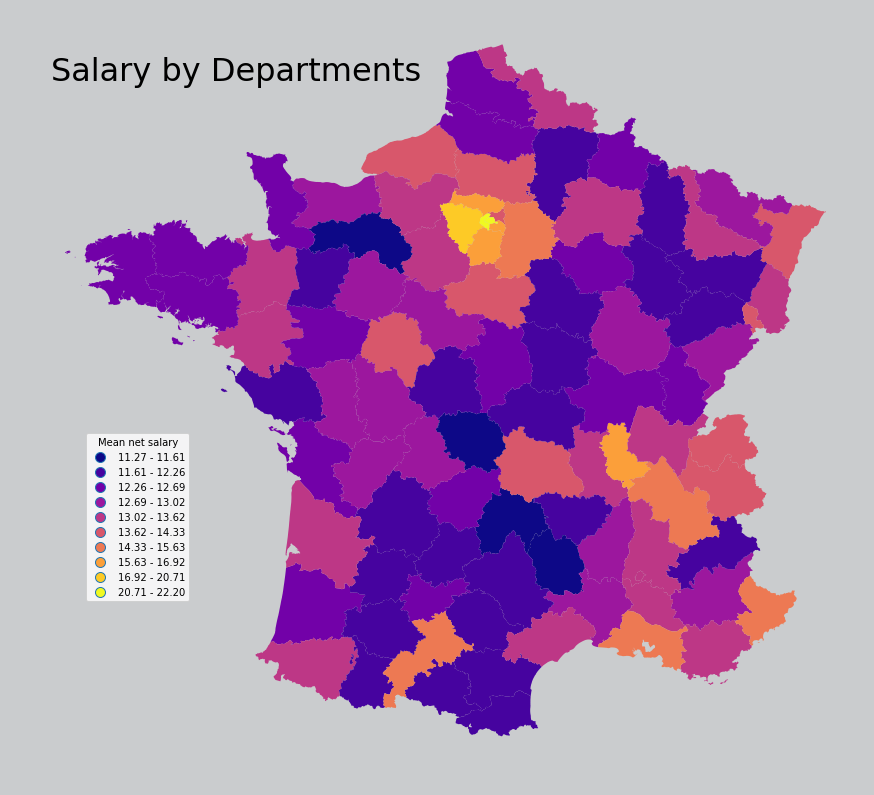

In [25]:
salaries_by_dep = salary_location.groupby("numéro_département").mean()
departments_map = departments_map.merge(salaries_by_dep, how="left", left_on="code", right_index=True)
departments_map.dropna(subset = ["longitude", "latitude"], inplace=True)

fig, ax = plt.subplots(1, figsize=(15,14))
ax.set_title('Salary by Departments', size=32, x = 0.25, y=0.90)
fig.patch.set_facecolor((202/255, 204/255, 206/255))
departments_map.plot(ax=ax, column="SNHM14", cmap=plt.cm.plasma, scheme='fisher_jenks', k=10, legend=True)
leg = ax.get_legend()
ax.set_axis_off()
leg.set_bbox_to_anchor((0., 0., 0.2, 0.45))
leg.set_title("Mean net salary")

<b>NOTE:</b> The visualization made clear that people living in close proximity to Paris earn on average more than the rest of the French population.

In [26]:
trace1 = go.Bar(
    x = ["Far [distance > 30km]", "Close [distance < 30km]"],
    y = salary_location.groupby("PARIS_CLOSE")["SNHM14"].mean().tolist(),
    name='Distance from Paris',
    marker=dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    )
)

data = [trace1]
layout = go.Layout(
    title = 'Distance from Paris',
    width=850,
    height=500,
    paper_bgcolor='rgb(202, 204, 206)',
    plot_bgcolor='rgb(202, 204, 206)',
    yaxis = dict(
        title= 'Average earnings [€/hour]',
        anchor = 'x',
        rangemode='tozero'
    ),
    xaxis = dict(title= 'Distance from Paris')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

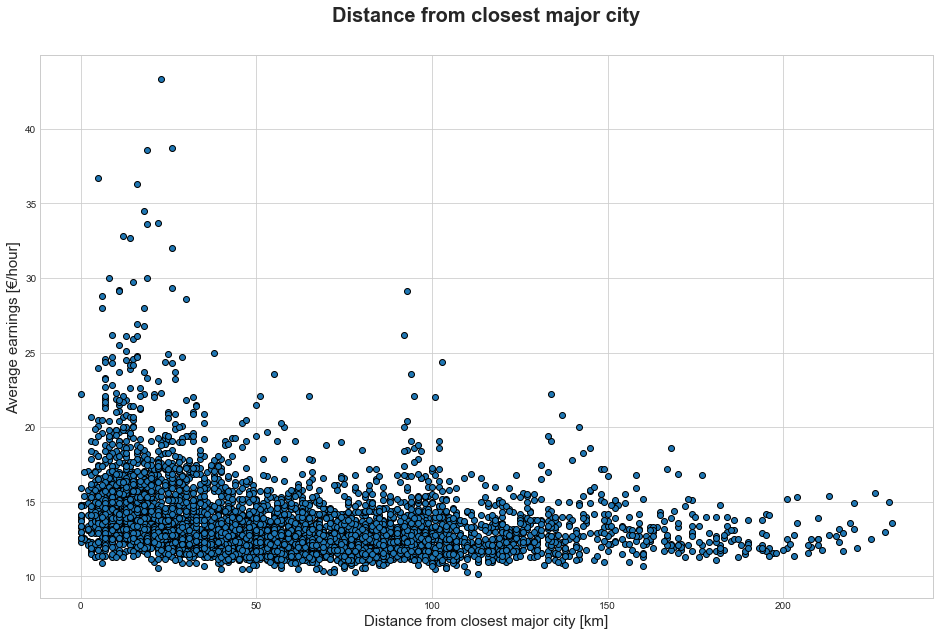

In [27]:
plt.figure(figsize=(16,10))
sns.set_style("whitegrid")
plt.title('Distance from closest major city', fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Distance from closest major city [km]', fontsize=15)
plt.ylabel('Average earnings [€/hour]', fontsize=15)

years = salary_location["MAJOR_CITY_DISTANCE"].values
memory = salary_location["SNHM14"].values

plt.scatter(years, memory, edgecolors='black')
plt.show()

### 2.4.3. Merging datasets
<a id="merging_datasets"></a>

In [29]:
# merging datasets
full_dataset = reformatted_salary.merge(geography, how="left", left_on='CODGEO', right_on="code_insee")
# deleting incomplete rows
full_dataset.dropna(inplace = True)
# selecting relevant columns
full_dataset = full_dataset[["POSITION", "SEX", "PARIS_CLOSE", "MAJOR_CITY_DISTANCE", "WAGE"]]

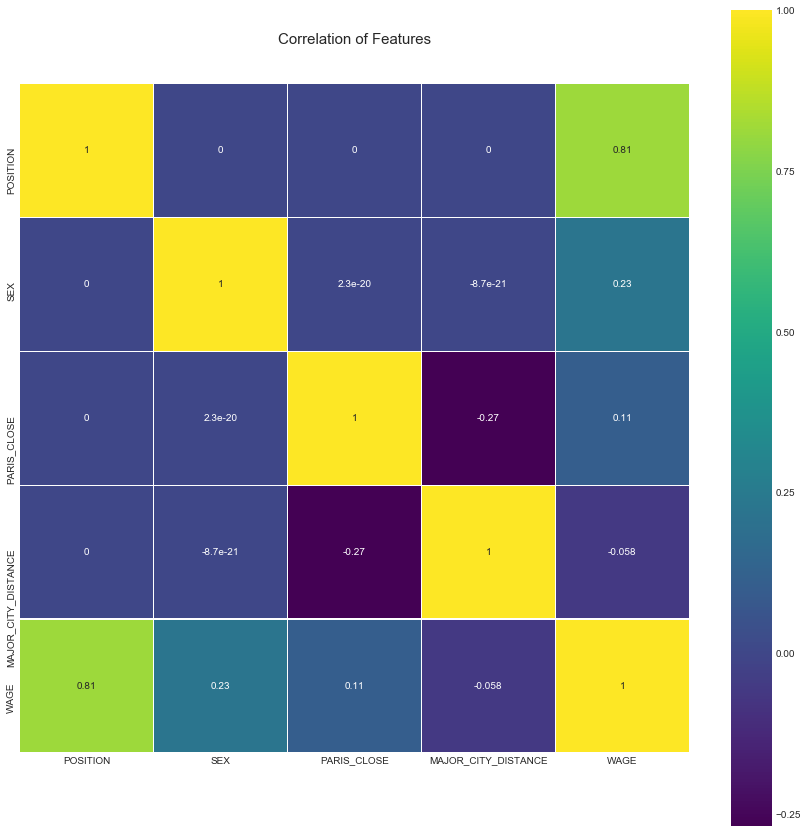

In [30]:
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(full_dataset.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

<b>NOTE:</b> The graph above illustrates the relationship between the successive features of the data set. As expected, the age has the greatest impact on the amount of money earned. The correlation between salary and other characteristics is also perceptible.

### 2.4.4. Splitting dataset into training and testset
<a id="splitting_dataset_into_training_and_testset"></a>

<b>NOTE:</b> First, we need to divide the dataset into matrix of features and vector of values.

In [31]:
X = full_dataset.iloc[:, :-1].values
y = full_dataset.iloc[:, 4].values

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

<b>NOTE:</b> Finally, we are ready to build a prediction model.

## 3. Prediction
<a id="prediction"></a>

### 3.1. Random Forest Regressor
<a id="random_forest_regressor"></a>

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

score = r2_score(y_pred, y_test)

In [35]:
score

0.87459621864351456

In [36]:
def standard_error(y_pred, y_test):
    sum_value = 0
    for p, t in zip(y_pred, y_test):
        sum_value += (p - t)**2
    
    return((sum_value/len(y_test))**(1/2))

In [37]:
standard_error(y_pred.tolist(), y_test.tolist())

1.822042462485544

# To be continued...